In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import pandas as pd
import json
from PIL import Image
import ipyplot
import random
from scipy.special import softmax
from scipy import stats
from scipy.stats import bernoulli
import random, math
import statsmodels.api as sm
import choix
import networkx as nx
from pathlib import Path
from shutil import copy2
from scipy import stats

#Fix the seed to reproduce the sampling
random_state = 42

## a) Load Twitter images

In [2]:
images_data_path = "data/manual_annotation/annotated.csv"
twitter_images = pd.read_csv(images_data_path)
twitter_images = twitter_images.loc[twitter_images['contains']=="1"]
twitter_images = twitter_images[['images', 'category']]
#number of unique food images
print(len(twitter_images['images'].unique()))
#remove due to annottaion inconsistency
twitter_images = twitter_images[twitter_images['category']!='fish']
categories_to_match = list(twitter_images['category'].unique())

3692


In [3]:
twitter_images.head()

,images,category
1,C_2B1WmXUAArQSi.jpg,spinach
2,C_2OXh0XoAE4onq.jpg,pasta OR noodles
3,C_43UkFXoAATq0Z.jpg,sauce
4,C_43UkFXoAATq0Z.jpg,spaghetti
5,C_4BeUeWsAAXaiL.jpg,salad


## b) Load real images

In [4]:
mappings = pd.read_csv("data/real_classes.csv")
mappings = mappings.dropna(subset = ['category_name'])
mappings = mappings[['name','category_name']]

In [5]:
annotation_file = "data/train/annotations.json"
f = open(annotation_file,)
data = json.load(f)
repo_images = pd.DataFrame(data['annotations'])\
        [['image_id', 'category_id']]

In [6]:
categories = pd.DataFrame(data['categories'])
repo_images = repo_images.merge(categories, how = 'left', 
                  left_on = 'category_id', right_on = 'id')[['image_id','name']]

In [7]:
repo_images = repo_images.merge(mappings, how = 'left',
                 on = 'name').\
        dropna(subset = ['category_name'])
repo_images = repo_images.loc[repo_images['category_name'].isin(categories_to_match)]

## c) Check frequencies

In [8]:
counts_repo = repo_images['category_name'].value_counts(normalize = True)
counts_twitter = twitter_images['category'].value_counts(normalize = True)

In [9]:
df_plt = pd.concat([counts_repo, counts_twitter], axis=1)

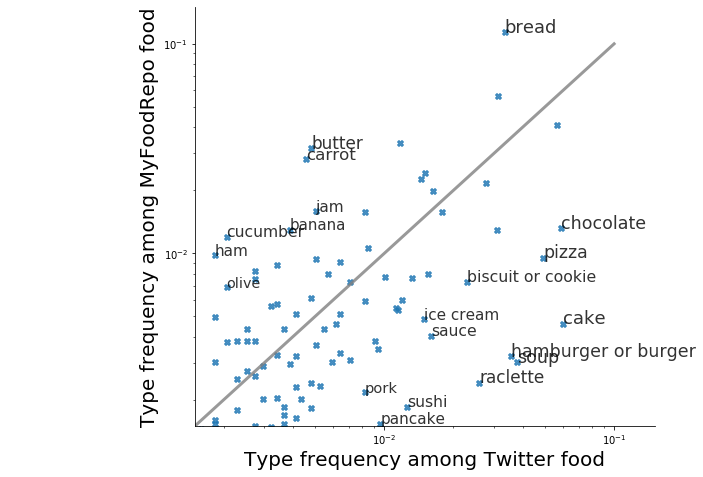

In [51]:
fig = plt.figure(figsize= (10,7))

ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xscale('log')
plt.yscale('log')

plt.plot([0,0.1],[0,0.1], linewidth = 3, color = 'gray', alpha = 0.8)

plt.scatter(df_plt['category'], df_plt['category_name'], marker = 'X', color = 'tab:blue', alpha = 0.8)

plt.xlabel('Type frequency among Twitter food', fontsize= 20)
plt.ylabel('Type frequency among MyFoodRepo food', fontsize= 20)

for cat,i in df_plt.iterrows():
    if i['category_name']*np.log(i['category_name']/i['category'])>0:
        t = i['category_name']*np.log(i['category_name']/i['category'])
        size = 10+1.3*np.log(t/0.15*500)
        
        if (i['category_name']-i['category'])/i['category']> 2:
            plt.annotate(cat.lower()[:20], (i['category'], i['category_name']), fontsize= size, alpha = 0.8, rotation = 0)
        else:
            plt.annotate("", (i['category'], i['category_name']), fontsize= size, alpha = 0.8, rotation = 10)
        
    
    if i['category']*np.log(i['category']/i['category_name'])>0:
        t = i['category']*np.log(i['category']/i['category_name']) 
        size = 10+1.3*np.log(t/0.15*500)
        
        if (i['category']-i['category_name'])/i['category_name']> 2:
            plt.annotate(cat.lower()[:20], (i['category'], i['category_name']),  fontsize= size, alpha = 0.8, rotation = 0)
        else:
            plt.annotate("", (i['category'], i['category_name']),  fontsize= size, alpha = 0.8, rotation = 10)
        
    #else
plt.xlim([0.0015, 0.15])
plt.ylim([0.0015, 0.15])


fig.tight_layout()

plt.savefig('figures/cats.pdf', bbox_inches='tight')

In [11]:
'''
fig = plt.figure(figsize= (8.5,6))

ax = plt.subplot(111)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xscale('log')
plt.yscale('log')

plt.plot([0,0.1],[0,0.1], linewidth = 3, color = 'gray', alpha = 0.8)

plt.scatter(df_plt['category'], df_plt['category_name'], marker = 'X', color = 'tab:blue', alpha = 0.8)

plt.xlabel('Category frequency among\nTwitter food images', fontsize= 16)
plt.ylabel('Category frequency among\nMyFoodRepo food images', fontsize= 16)

for cat,i in df_plt.iterrows():
    if i['category_name']*np.log(i['category_name']/i['category'])>0.02:
        plt.annotate(cat.lower()[:20], (i['category'], i['category_name']), fontsize= 16, rotation = 10)
    
    
    if i['category']*np.log(i['category']/i['category_name'])>0.01:
        plt.annotate(cat.lower()[:20], (i['category'], i['category_name']), fontsize= 16, rotation = 10)
    
    #else
plt.xlim([0.0015, 0.15])
plt.ylim([0.0015, 0.15])


fig.tight_layout()

plt.savefig('figures/cats.pdf', bbox_inches='tight')
''';

In [12]:
p = counts_repo.sort_index()
q = counts_twitter.sort_index()

In [13]:
stats.spearmanr(p.values, q.values)

SpearmanrResult(correlation=0.4913540094109826, pvalue=8.48810488561687e-11)

In [14]:
stats.pearsonr(p.values, q.values)

(0.44453063851394, 6.852613587825045e-09)

In [15]:
(p * np.log(p / q)).sort_values(ascending = False)[:10]

bread             0.138958
butter            0.059910
carrot            0.051327
salad dressing    0.041057
tomato            0.035712
salad             0.033143
cucumber          0.021246
jam               0.018220
tomato sauce      0.017338
parmesan          0.016576
dtype: float64

In [16]:
(q * np.log(q / p)).sort_values(ascending = False)[:10]

cake                   0.152739
soup                   0.095333
chocolate              0.088504
hamburger OR burger    0.085622
pizza                  0.080564
raclette               0.061206
chicken                0.026911
biscuit OR cookie      0.026050
sushi                  0.024083
sauce                  0.021989
dtype: float64

In [17]:
(q['soup'] - p['soup'] ) / p['soup'] 

11.511147953350102

In [18]:
(q['cake'] - p['cake'] ) / p['cake'] 

11.924317588915283

In [19]:
(q['raclette'] - p['raclette'] ) / p['raclette'] 

9.682481936083583

In [20]:
(q['hamburger OR burger'] - p['hamburger OR burger'] ) / p['hamburger OR burger'] 

10.024827993490504

In [21]:
(p['bread'] - q['bread'] ) / q['bread'] 

2.4005631448667146

In [22]:
(p['butter'] - q['butter'] ) / q['butter'] 

5.607202695101664

In [23]:
q['hamburger OR burger']

0.03567345072032929

In [24]:
# convert to 1 in X

1/0.0357

28.011204481792713

In [25]:
len(q)

155

## d) Setup study design

### For each category, create candidate images, such that there is equal number of real images and twitter images (this implies subsampling real images, except for cake, hamburger OR burger, raclette, soup where we subsample Twitter images

### First we check how many images we can have competing in each category

In [26]:
random.seed(10)

list_candidates = []

for category in categories_to_match:

    tmp_t = twitter_images.loc[twitter_images\
                                   ['category'] == category]['images']
    tmp_r = repo_images.loc[repo_images\
                                   ['category_name'] == category]
    
    num_t = (len(tmp_t))
    num_r = (len(tmp_r))

    
    if num_t<=num_r:
        r_list = tmp_r.sample(num_t, random_state = random_state)['image_id'].values
        t_list = list(tmp_t.values)
        
        for i in range(num_t):
            entry = {}
            entry['type'] = 'T'
            entry['image'] = t_list[i]
            entry['category'] = category
            list_candidates.append(entry)
            
            entry = {}
            entry['type'] = 'R'
            entry['image'] = r_list[i]
            entry['category'] = category
            list_candidates.append(entry)
        
    else:
        print(category)
        r_list = tmp_r['image_id'].values
        t_list = list(tmp_t.sample(num_r, random_state = random_state).values)
        
        for i in range(num_r):
            entry = {}
            entry['type'] = 'T'
            entry['image'] = t_list[i]
            entry['category'] = category
            list_candidates.append(entry)
            
            entry = {}
            entry['type'] = 'R'
            entry['image'] = r_list[i]
            entry['category'] = category
            list_candidates.append(entry)

cake
hamburger OR burger
raclette
soup


In [27]:
candidates = pd.DataFrame(list_candidates)

In [28]:
candidates

,type,image,category
0,T,C_2B1WmXUAArQSi.jpg,spinach
1,R,101372,spinach
2,T,D-aYp7qW4AID_Ib.jpg,spinach
3,R,69306,spinach
4,T,D0pJ3Y1WwAAzo20.jpg,spinach
...,...,...,...
8197,R,40084,nectarine
8198,T,EVGaW0kVAAAj1js.jpg,nectarine
8199,R,69029,nectarine
8200,T,EWnx18zXsAEqm9h.jpg,nectarine


In [29]:
# we take categories with at least 100 competing images
# (we disregard small categories of food)
# by doing so, we take 24 categories of food, 
# all with at least 100 competing images

In [30]:
categories = list(candidates['category'].value_counts()[:24].index)

In [31]:
candidates = candidates.loc[candidates['category'].isin(categories)]

In [32]:
(candidates['category'].value_counts().values[\
                            candidates['category'].value_counts().values  >= 100])

array([516, 496, 430, 294, 292, 274, 270, 242, 206, 200, 192, 156, 154,
       142, 140, 136, 132, 130, 126, 116, 110, 104, 102, 100])

In [33]:
candidates.head()

,type,image,category
42,T,C_2OXh0XoAE4onq.jpg,pasta OR noodles
43,R,24047,pasta OR noodles
44,T,C_oas0fXYAAV4sv.jpg,pasta OR noodles
45,R,57788,pasta OR noodles
46,T,C10A1srXEAA31mc.jpg,pasta OR noodles


In [34]:
(candidates['category'].value_counts())

chocolate              516
cheese                 496
pizza                  430
cake                   294
bread                  292
salad                  274
chicken                270
pasta OR noodles       242
hamburger OR burger    206
biscuit OR cookie      200
soup                   192
potato                 156
raclette               154
egg                    142
sauce                  140
croissant              136
rice                   132
ice cream              130
vegetable              126
beef                   116
sushi                  110
mushroom               104
tomato                 102
curry                  100
Name: category, dtype: int64

## e) Do the final sampling of images that will compete

### We sample 100 competing images from each of the 24 categories (24 categories exist with at least 100 images that can compete)
### 2400 photos
### 62,500 posible comparisons

In [35]:
random.seed(10)

list_candidates = []
n_samples = 50

for category in categories:

    tmp_t = twitter_images.loc[twitter_images\
                                   ['category'] == category]['images']
    tmp_r = repo_images.loc[repo_images\
                                   ['category_name'] == category]
    
    tmp_r = tmp_r.drop_duplicates(subset = ['image_id', 'category_name'])
    
    r_list = tmp_r.sample(n_samples, random_state = random_state, replace = False)['image_id'].values
    t_list = list(tmp_t.sample(n_samples, random_state = random_state, replace = False).values)

    for i in range(n_samples):
        entry = {}
        entry['type'] = 'T'
        entry['image'] = t_list[i]
        entry['category'] = category
        list_candidates.append(entry)

        entry = {}
        entry['type'] = 'R'
        entry['image'] = r_list[i]
        entry['category'] = category
        list_candidates.append(entry)
    

In [36]:
samples = pd.DataFrame(list_candidates)

In [37]:
len(samples)

2400

In [38]:
categories

['chocolate',
 'cheese',
 'pizza',
 'cake',
 'bread',
 'salad',
 'chicken',
 'pasta OR noodles',
 'hamburger OR burger',
 'biscuit OR cookie',
 'soup',
 'potato',
 'raclette',
 'egg',
 'sauce',
 'croissant',
 'rice',
 'ice cream',
 'vegetable',
 'beef',
 'sushi',
 'mushroom',
 'tomato',
 'curry']

## f) Rank, sample votes, and simulate estimation of the rank with BT

In [39]:
np.random.seed(0) 

#tastines is modelled with (0,1) normal distribution for Real
#and (deltamu,1) normal distribution for Twitter
mu = 0
sigma = 1
delta_mu = 0

quality_real = np.random.normal(mu, sigma, 50)
quality_twitter = np.random.normal(mu+delta_mu, sigma, 50)

In [40]:
df_rankings = pd.DataFrame()
df_rankings['image_id'] = [i for i in range(50)] + [i+50 for i in range(50)]
df_rankings['quality'] = np.concatenate((quality_real, quality_twitter))

In [41]:
df_rankings['rank'] = df_rankings['quality'].rank(method = 'average',
         ascending = False)

In [42]:
df_rankings.sort_values(by = 'rank')

,image_id,quality,rank
24,24,2.269755,1.0
3,3,2.240893,2.0
43,43,1.950775,3.0
85,85,1.895889,4.0
4,4,1.867558,5.0
...,...,...,...
66,66,-1.630198,96.0
42,42,-1.706270,97.0
63,63,-1.726283,98.0
33,33,-1.980796,99.0


## Simulate estimation

In [43]:
# simulate datacollection of paired comparisons
# each vote Real vs Twitter is established by
# tossing a coin p(Twitter wins) = p(Twitter prior better) 

In [44]:
data = []

tmp_real = df_rankings.loc[df_rankings['image_id']<50]
tmp_twitter = df_rankings.loc[df_rankings['image_id']>=50]

n_comparisons = 500

for iter_ in range(10):
    #sample one real
    #sample one twitter
    

    tmp_real = df_rankings.loc[df_rankings['image_id']<50].sample(frac=1)
    tmp_twitter = df_rankings.loc[df_rankings['image_id']>=50].sample(frac=1)

    for i in range(50):
        #sample one real
        #sample one twitter

        sample_real = tmp_real.iloc[i]
        sample_twitter = tmp_twitter.iloc[i]

        #look at ground truth
        if sample_twitter['quality'] > sample_real['quality']:
            #twitter won
            data.append((int(sample_twitter['image_id']),
                         int(sample_real['image_id'])))
        else:
            #real won
            data.append((int(sample_real['image_id']),
                         int(sample_twitter['image_id'])))

In [45]:
G = nx.Graph()
G.add_edges_from(data)

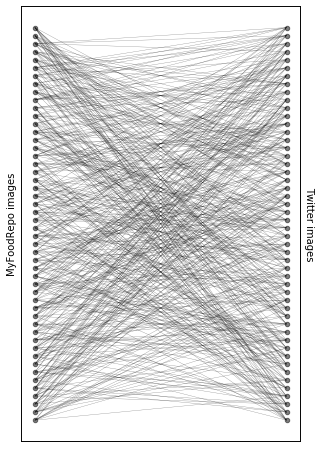

In [46]:
fig, ax = plt.subplots(1,1,figsize= (5,8))
pos = nx.bipartite_layout(G, nodes = range(50))
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_size = 20, node_color = 'black', alpha = 0.5)
nx.draw_networkx_edges(G, pos, width = 0.3, alpha = 0.5)
plt.ylabel('MyFoodRepo images')

plt.yticks([])
ax.yaxis.tick_right()
ax2 = ax.twinx()
ax2.set_yticks([]);
ax2.set_ylabel('Twitter images', rotation = -90)
ax2.yaxis.set_label_coords(1.05,0.5)


In [47]:
n_items = 100

In [48]:
estimations = choix.ilsr_pairwise(n_items, data, alpha=0.01)

In [49]:
df_estimations = pd.DataFrame()
df_estimations['image_id'] = range(100)
df_estimations['estimated'] = estimations

In [50]:
df_estimations['rank'] = df_estimations['estimated'].rank(method = 'average',
         ascending = False)

In [51]:
df_estimations.iloc[:50]['rank'].mean()

47.02

In [52]:
df_estimations.iloc[50:]['rank'].mean()

53.98

In [53]:
tau, p_value = stats.kendalltau(df_estimations['rank'],
                                df_rankings['rank'])

Text(0, 0.5, 'Estimated rank')

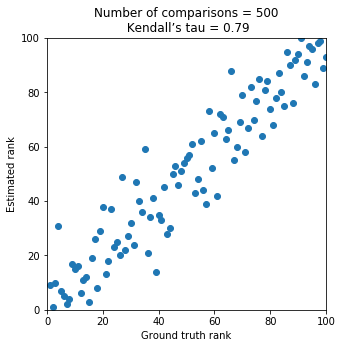

In [54]:
fig, axes = plt.subplots(1,1,figsize= (5,5))

plt.title('Number of comparisons = '+str(n_comparisons)+
         '\n Kendall’s tau = '+str(tau)[:4])
plt.scatter(df_rankings['rank'], df_estimations['rank'])
plt.xlim([0,100])
plt.ylim([0,100])
plt.xlabel('Ground truth rank')
plt.ylabel('Estimated rank')

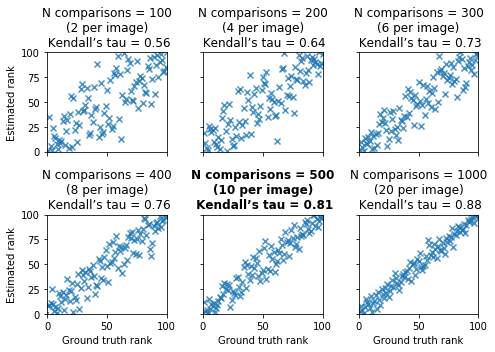

In [61]:
fig, ax = plt.subplots(2,3,figsize= (7,5), sharey = True, sharex = True)



tmp_real = df_rankings.loc[df_rankings['image_id']<50]
tmp_twitter = df_rankings.loc[df_rankings['image_id']>=50]

for cnt,n_comparisons in enumerate([100,400,200,500,300,1000]):
    
    sbplt = ax[cnt%2, math.floor(cnt/2)]
    sbplt.plot([0,1],[0,1])
    data = []
    
    for iter_ in range(int(n_comparisons/50)):

        tmp_real = df_rankings.loc[df_rankings['image_id']<50].sample(frac=1)
        tmp_twitter = df_rankings.loc[df_rankings['image_id']>=50].sample(frac=1)

        for i in range(50):
            #sample one real
            #sample one twitter

            sample_real = tmp_real.iloc[i]
            sample_twitter = tmp_twitter.iloc[i]



            '''
            #convert ground truth quality to probability with softmax
            p_twitter = softmax([sample_twitter['quality'].values[0], 
                sample_real['quality'].values[0]])[0]

            if bernoulli.rvs(p_twitter)==1:
                #twitter won
                data.append((sample_twitter['image_id'].values[0],
                             sample_real['image_id'].values[0]))
            else:
                #real won
                data.append((sample_real['image_id'].values[0],
                             sample_twitter['image_id'].values[0]))
            ''' 

            #look at ground truth
            if sample_twitter['quality'] > sample_real['quality']:
                #twitter won
                data.append((int(sample_twitter['image_id']),
                             int(sample_real['image_id'])))
            else:
                #real won
                data.append((int(sample_real['image_id']),
                             int(sample_twitter['image_id'])))

    G = nx.Graph()
    
    #we build a dominance graph
    G.add_edges_from(data)
    #print('Is fully connected:',nx.is_connected(G))
    
    #we estimate latent quality with likelyhood maximization
    estimations = choix.ilsr_pairwise(n_items, data, alpha=0.01)
    df_estimations = pd.DataFrame()
    df_estimations['image_id'] = range(100)
    df_estimations['estimated'] = estimations
    df_estimations['rank'] = df_estimations['estimated'].rank(method = 'average',
         ascending = False)
    tau, p_value = stats.kendalltau(df_estimations['rank'],
                                df_rankings['rank'])
    
    
    if n_comparisons ==500:
        sbplt.set_title('N comparisons = '+str(n_comparisons)+ "\n("+str(int(n_comparisons/50))+" per image)"+
         '\n Kendall’s tau = '+str(tau)[:4],fontweight='bold')
    else:
        sbplt.set_title('N comparisons = '+str(n_comparisons)+ "\n("+str(int(n_comparisons/50))+" per image)"+
         '\n Kendall’s tau = '+str(tau)[:4])
    sbplt.scatter(df_rankings['rank'], df_estimations['rank'], marker = 'x',color = 'tab:blue', alpha = 0.8)
    sbplt.set_xlim([0,100])
    sbplt.set_ylim([0,100])

    if cnt ==1 or cnt ==3 or cnt ==5:
        sbplt.set_xlabel('Ground truth rank')
    if cnt ==0 or cnt==1:
        sbplt.set_ylabel('Estimated rank')
    
fig.tight_layout()

plt.savefig('figures/simulations.pdf', bbox_inches='tight')

## g) Generate input files

In [56]:
dict_human_names = {
    'beef': 'contains beef that appears',
    'biscuit OR cookie': 'contains biscuit(s) or cookie(s) that appear',
    'bread': 'contains bread that appears',
    'cake': 'contains cake that appears',
    'cheese': 'contains cheese that appears',
    'chicken': 'contains chicken that appears',
    'chocolate': 'contains chocolate that appears',
    'croissant': 'contains croissant(s) that appear',
    'curry': 'contains curry that appears',
    'egg': 'contains egg(s) that appear',
    'fish': 'contains fish that appears',
    'hamburger OR burger': 'contains burger(s) that appear',
    'ice cream': 'contains ice cream that appears',
    'mushroom': 'contains mushroom(s) that appear',
    'pasta OR noodles': 'contains pasta or noodles that appear',
    'pizza': 'contains pizza that appears',
    'potato': 'contains potato(s) that appear',
    'raclette': 'contains raclette that appears',
    'rice': 'contains rice that appears',
    'salad': 'contains salad that appears',
    'sauce': 'contains sauce that appears',
    'soup': 'contains soup that appears',
    'sushi': 'contains sushi that appears',
    'tomato': 'contains tomato(es) that appear',
    'vegetable': 'contains vegetable(s) that appear'
}

dict_clean_cats = {
    'beef': 'beef',
    'biscuit OR cookie': 'biscuit or cookie',
    'bread': 'bread',
    'cake': 'cake',
    'cheese': 'cheese',
    'chicken': 'chicken',
    'chocolate': 'chocolate',
    'croissant': 'croissant',
    'curry': 'curry',
    'egg': 'egg',
    'fish': 'fish',
    'hamburger OR burger': 'burger',
    'ice cream': 'ice cream',
    'mushroom': 'mushroom',
    'pasta OR noodles': 'pasta or noodles',
    'pizza': 'pizza',
    'potato': 'potato',
    'raclette': 'raclette',
    'rice': 'rice',
    'salad': 'salad',
    'sauce': 'sauce',
    'soup': 'soup',
    'sushi': 'sushi',
    'tomato': 'tomato',
    'vegetable': 'tegetable'
}

In [51]:
#10 times
    #shuffle tmp_real
    #shuffle tmp_twitter
    #make 50 comparisons by iterating through shuffled tmp real, tmp twitter
    

random.seed(10)
np.random.seed(10) 

for cat,gr in samples.groupby('category'):
    list_randomized_comparisons = []
    
    for iter_ in range(10):
        tmp_real = gr.loc[gr['type'] == 'R'].sample(frac=1)
        tmp_twitter = gr.loc[gr['type'] == 'T'].sample(frac=1)

        for i in range(50):
            #sample one real
            #sample one twitter
            entry = {}
            sample_real = tmp_real.iloc[i]
            sample_twitter = tmp_twitter.iloc[i]

            entry['prompt_fill'] = dict_human_names[cat]
            entry['category'] = cat
            entry['foodtype'] = dict_clean_cats[cat]

            #flip a coin to randomize order

            if bernoulli.rvs(0.5)==1:
                name = sample_real['image']
                entry['image_1_url_full'] = 'anonymized/'+f"{(name):06d}.jpg"
                entry['image_2_url_full'] = 'anonymized/'+sample_twitter['image']
                entry['image_1_url'] = 'anonymized/'+f"{(name):06d}.jpg"
                entry['image_2_url'] = 'anonymized/'+sample_twitter['image'][-10:]
                entry['image_1'] = 'R'
                entry['image_2'] = 'T'
            else:
                name = sample_real['image']
                entry['image_1_url_full'] = 'anonymized/'+sample_twitter['image']
                entry['image_2_url_full'] = 'anonymized/'+f"{(name):06d}.jpg"
                entry['image_1_url'] = 'anonymized/'+sample_twitter['image'][-10:]
                entry['image_2_url'] = 'anonymized/'+f"{(name):06d}.jpg"
                entry['image_1'] = 'T'
                entry['image_2'] = 'R'
            list_randomized_comparisons.append(entry)

    df_input = pd.DataFrame(list_randomized_comparisons)
    df_input.to_csv('crowdsourced_annotation_input/'+cat+'.csv', index = False)
    print(cat)
    print('Number of competing images:',len(pd.Series(list(df_input['image_1_url'].values) + list(df_input['image_2_url'].values)).unique()))
    print('Number of times each image competes:', np.unique(pd.Series(list(df_input['image_1_url'].values) + list(df_input['image_2_url'].\
                                                                values)).value_counts().values)[0])
    print('Number of comparisons:', len(df_input))
    print('\n')

beef
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


biscuit OR cookie
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


bread
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


cake
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


cheese
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


chicken
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


chocolate
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


croissant
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


curry
Number of competing images: 100
Number of times each image competes: 10
Number of comparisons: 500


egg
Number of co

In [52]:
for cat,gr in samples.groupby('category'):
    Path("images_competing/"+cat).mkdir(parents=True, exist_ok=True)

In [55]:
#copy the competing images to a folder to be uploaded


for cat,gr in samples.groupby('category'):
    d = pd.read_csv('crowdsourced_annotation_input/'+cat+'.csv')
    print(cat)
    
    checked = []
    for cnt,row in d.iterrows():        
        if row['image_1'] == 'T':
            #twitter
            name = row['image_1_url_full'].split('/')[-1]
            if name not in checked:
                copy2("data/twitter_extended_plural/"+cat
                   +"/CH/"+name,\
                     "data/images_competing/"+cat+"/"+name[-10:])
                checked.append(name)
            
            #real
            name = row['image_2_url_full'].split('/')[-1]
            if name not in checked:
                copy2(f"data/train/images/{int(name.split('.jpg')[0]):06d}.jpg",\
                    "data/images_competing/"+cat+"/")
                checked.append(name)
                
        else:
            #tw
            name = row['image_2_url_full'].split('/')[-1]
            if name not in checked:
                copy2("data/twitter_extended_plural/"+cat
                   +"/CH/"+name,\
                     "data/images_competing/"+cat+"/"+name[-10:])
                checked.append(name)
            #re
            name = row['image_1_url_full'].split('/')[-1]
            if name not in checked:
                copy2(f"data/train/images/{int(name.split('.jpg')[0]):06d}.jpg",\
                    "data/images_competing/"+cat+"/")
                checked.append(name)


beef
biscuit OR cookie
bread
cake
cheese
chicken
chocolate
croissant
curry
egg
fish
hamburger OR burger
ice cream
mushroom
pasta OR noodles
pizza
potato
raclette
rice
salad
sauce
soup
sushi
tomato
vegetable
